<a href="https://colab.research.google.com/github/Sunday-Okey/Adventure_game/blob/master/NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import the libraries
import collections
import re
import numpy as np
from keras import optimizers

from keras.preprocessing.text import Tokenizer
# from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import LSTM, GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout
from tensorflow.keras.layers import Embedding
from nltk.translate.bleu_score import corpus_bleu
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.models import load_model
import os
import string
import requests
from keras.utils import pad_sequences
import unicodedata
from keras.callbacks import ModelCheckpoint
import regex

In [3]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NLP_Final_Project/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)



Your working directory was changed to /content/drive/My Drive/Colab Notebooks/NLP_Final_Project/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Extract the file

In [10]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text


In [11]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t')[:-1] for i in sents]
    return sents

In [12]:
pwd

'/content/drive/My Drive/Colab Notebooks/NLP_Final_Project'

In [13]:
data = read_text("fra.txt")
frn_eng = to_lines(data)
# frn_eng[:210000][-3]
# len(frn_eng)

In [14]:
ascii_string = regex.sub(r'[^\x00-\x7f]', r'', "«\xa0Je pense qu'on ne devrait pas faire ça.\xa0» «\xa0Personne ne vous a demandé votre avis.\xa0»")
ascii_string

"Je pense qu'on ne devrait pas faire a. Personne ne vous a demand votre avis."

In [15]:
unicodedata.normalize("NFKD", 'Cours\u202f!')

'Cours !'

In [16]:
frn_eng = frn_eng[:210000]
len(frn_eng)

210000

Lets read in the data

In [17]:
# Open a file in append mode
with open('small_vocab_en', 'a') as file1, open('small_vocab_fr', 'a') as file2:
  for i in range(len(frn_eng)):
      file1.write(frn_eng[i][0] + '\n')
      file2.write(frn_eng[i][1] + '\n')


In [18]:
def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r", encoding='utf-8') as f:
        data = f.read()

    return data.split('\n')

In [19]:
# Load English data
english_sentences = load_data('small_vocab_en')
# Load French data
french_sentences = load_data('small_vocab_fr')

In [20]:
len(english_sentences)

347861

In [21]:
len(french_sentences)

347861

In [22]:
# Remove punctuation
english_sentences = [s.translate(str.maketrans('', '', string.punctuation)) for s in english_sentences]
french_sentences = [s.translate(str.maketrans('', '', string.punctuation)) for s in french_sentences]

In [23]:
# convert to lowercase
for i in range(len(english_sentences)):
    english_sentences[i] = english_sentences[i].lower()
    
    french_sentences[i] = french_sentences[i].lower()

    english_sentences[i] = regex.sub(r'[^\x00-\x7f]', r'', english_sentences[i])
    french_sentences[i] = regex.sub(r'[^\x00-\x7f]', r'', french_sentences[i])

In [24]:
# empty lists
eng_l = []
frn_l = []

# populate the lists with sentence lengths
for i in english_sentences:
    eng_l.append(len(i))

for i in french_sentences:
    frn_l.append(len(i))

In [25]:
max(eng_l)

100

In [26]:
max(frn_l)

111

In [27]:
import pandas as pd
length_df = pd.DataFrame({'eng':eng_l, 'frn':frn_l})

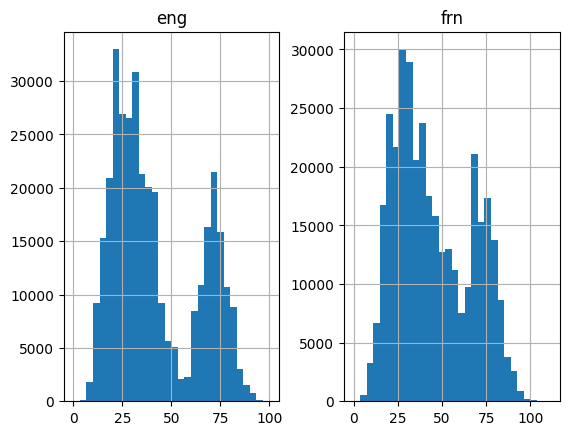

In [28]:
import matplotlib.pyplot as plt
length_df.hist(bins = 30)
plt.show()

In [29]:
print(max(eng_l), max(frn_l))

100 111


In [30]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [31]:
# prepare english tokenizer
eng_tokenizer = tokenization(english_sentences)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 100
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 15251


In [32]:
# prepare French tokenizer
frn_tokenizer = tokenization(french_sentences)
frn_vocab_size = len(frn_tokenizer.word_index) + 1

frn_length = 111
print('French Vocabulary Size: %d' % frn_vocab_size)

French Vocabulary Size: 29519


In [33]:
#encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [34]:
from sklearn.model_selection import train_test_split
frn_train, frn_test1, eng_train, eng_test1 = train_test_split(french_sentences,english_sentences, test_size=0.01, random_state = 12)


In [35]:
len(frn_train)

344382

In [36]:
len(frn_test1)

3479

In [37]:
len(eng_train)

344382

In [38]:
len(eng_test1)

3479

In [39]:
# prepare training data
frn_train = encode_sequences(frn_tokenizer, frn_length, frn_train)
eng_train = encode_sequences(eng_tokenizer, eng_length, eng_train)

In [40]:
# prepare validation data
frn_test = encode_sequences(frn_tokenizer, frn_length, frn_test1)
eng_test = encode_sequences(eng_tokenizer, eng_length, eng_test1)

In [41]:

def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units)))
    model.add(RepeatVector(out_timesteps))
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Dense(out_vocab, activation='softmax'))

    return model

In [42]:
model = build_model(frn_vocab_size, eng_vocab_size, frn_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 111, 512)          15113728  
                                                                 
 bidirectional (Bidirectiona  (None, 111, 1024)        4198400   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 1024)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024)             6295552   
 nal)                                                            
                                                                 
 repeat_vector (RepeatVector  (None, 100, 1024)        0         
 )                                                               
                                                        

In [44]:
frn_train.shape

(344382, 111)

In [45]:
pwd

'/content/drive/MyDrive/Colab Notebooks/NLP_Final_Project'

In [46]:
eng_train.shape

(344382, 100)

In [64]:
# filename = 'model.h1.24_jan_18'
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# history = model.fit(frn_train, eng_train.reshape(eng_train.shape[0], eng_train.shape[1], 1),epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

In [65]:
model = load_model("model.h1.24_jan_19")

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
# preds = model.predict(frn_test.reshape((frn_test.shape[0],frn_test.shape[1])))

In [66]:
import numpy as np

def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [67]:
test_x = frn_test.reshape((frn_test.shape[0],frn_test.shape[1]))
test_x[:4][1]

array([  21,  213,    9,    5,  472,    9,   19,   13,  144, 2678,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [68]:
test = ['Elle étudie pour devenir médecin.', 'Le restaurant sert une nourriture délicieuse.']

In [69]:
test = encode_sequences(frn_tokenizer, frn_length, test)
# test = test.reshape((test.shape[0],test.shape[1]))

In [70]:
test.shape

(2, 111)

In [71]:
test = test.reshape((test.shape[0],test.shape[1]))

In [72]:
test.shape

(2, 111)

In [73]:
# print(logits_to_text(model.predict(test_x[:4][1], eng_tokenizer)))
print(logits_to_text(model.predict(frn_test[:20])[10], eng_tokenizer))

# print(logits_to_text(model.predict(test_x[:4])[3], eng_tokenizer))

1/1 [==============================] - 5s 5s/step
they dislike peaches oranges and bananas <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [75]:
eng_test1[10]

'they dislike peaches  oranges  and bananas '

In [76]:
frn_test1[10]

'ils naiment les pches  les oranges et les bananes '

In [77]:
test_x

array([[  3, 367, 128, ...,   0,   0,   0],
       [ 21, 213,   9, ...,   0,   0,   0],
       [ 10,  70,  66, ...,   0,   0,   0],
       ...,
       [ 10, 129,  13, ...,   0,   0,   0],
       [  5,  47,   1, ...,   0,   0,   0],
       [ 77,   1, 124, ...,   0,   0,   0]], dtype=int32)

In [78]:
frn_test1[3]

'je veux prsenter mes excuses'

In [79]:
eng_test1[3]

'i want to apologize'

In [80]:
source_str, target_str = "French", "English"

def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_src, raw_tar, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, eng_tokenizer, source)
        raw_src = frn_test1[i]
        raw_tar = eng_test1[i]
        
        print(f'{raw_src:30} {raw_tar:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, eng_tokenizer, frn_test, frn_test1, eng_test1)

### Result on the Training Set ###


### Result on the Test Set ###
FRENCH (SOURCE)                ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

il semble quil y ait eu l une erreur there appears to have been a mistake there seems there be there a mistake
vous avez de la chance de ne pas tre mortes youre lucky you didnt die youre lucky you didnt be
je me suis cach derrire un rideau i hid myself behind a curtain i hid myself in a
je veux prsenter mes excuses   i want to apologize       i want to apologize
je peux avoir un clin          can i have a hug          i can give a hug
france est gnralement sec en dcembre  mais il est pluvieux en juillet  france is usually dry during december  but it is rainy in july  france is usually dry during december but it is rainy in july
seraistu dispose  partager ton code avec moi  would you be willing to share your code with me would you be willing to share your code with me
je rentrerai tard ce soir      ill be back late tonight  ill ge

In [62]:
# It takes long to compute the BLEU Score

def bleu_score(model, tokenizer, sources, raw_src, raw_tar):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, eng_tokenizer, source)
        raw_src = frn_test1[i]
        raw_tar = eng_test1[i]
        actual.append([raw_tar])
        predicted.append(translation)
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

# Compute the BLEU Score
# bleu_train = bleu_score(model, eng_tokenizer, frn_train1, frn_t1)
bleu_test = bleu_score(model, eng_tokenizer, frn_test, frn_test1, eng_test1)

In [63]:
bleu_test

{'1-grams': 0.8787440241129639,
 '1-2-grams': 0.8546182120974017,
 '1-3-grams': 0.8449712336285509,
 '1-4-grams': 0.8178677566126499}

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()

In [ ]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NLP_Final_Project/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)

In [ ]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NLP_Final_Project/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)
